# Optimización del Chunk Size para un Sistema RAG

Este notebook analiza los resultados experimentales obtenidos al variar el tamaño de fragmentación (chunk size), utilizando la métrica de distancia L2 normalizada como base para estimar la relevancia, con el fin de determinar el valor óptimo basado en los puntajes de relevancia de los documentos recuperados.

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

with open("results.json", "r", encoding="utf-8") as f:
    data = json.load(f)

### Cálculo de la Relevancia Normalizada

En este experimento, usamos la distancia euclidiana (L2) entre los embeddings normalizados del query y de cada documento para estimar la **relevancia**.

Dado que estamos usando vectores **L2-normalizados**, la distancia L2 entre dos vectores \( u \) y \( v \) está acotada en el rango \([0, 4]\), donde:

- \( 0 \): Máxima similitud → vectores idénticos.
- \( 4 \): Mínima similitud → vectores opuestos.

Para convertir esta métrica en una escala de **relevancia normalizada entre 0 y 1**, usamos la siguiente fórmula:

$$
\text{Relevancia} = 1 - \frac{\text{distancia\_L2}}{4}
$$

De este modo:

- Una distancia L2 de `0` da una relevancia de `1.0` (muy relevante).
- Una distancia de `4` da una relevancia de `0.0` (nada relevante).

Este valor de relevancia es el que se utilizó para los análisis visuales y estadísticos del experimento.

In [20]:
filas = []
for entrada in data:
    size = entrada["size"]
    for resultado in entrada["results"]:
        query = resultado["query"]
        scores = resultado["scores"]
        for score in scores:
            relevance = 1 - min(score, 4) / 4
            filas.append({
                "chunk_size": size,
                "query": query,
                "score": score,
                "relevance": relevance
            })

df = pd.DataFrame(filas)

In [21]:
agrupado = df.groupby("chunk_size").agg(
    media=("relevance", "mean"),
    mediana=("relevance", "median"),
    desviacion_std=("relevance", "std"),
    maximo=("relevance", "max"),
    minimo=("relevance", "min"),
    percentil_90=("relevance", lambda x: np.percentile(x, 90))
).reset_index()

agrupado.sort_values("media", ascending=True)
agrupado.head(15)

,chunk_size,media,mediana,desviacion_std,maximo,minimo,percentil_90
0,137,0.714724,0.710831,0.046736,0.935385,0.607170,0.775245
1,154,0.712113,0.709094,0.044926,0.904555,0.603386,0.772055
2,158,0.711668,0.709698,0.045052,0.901142,0.602357,0.770579
3,186,0.707664,0.703670,0.044943,0.903316,0.600403,0.765101
4,191,0.707010,0.701230,0.045296,0.903316,0.599471,0.766207
5,196,0.706497,0.701650,0.045539,0.909344,0.599471,0.766909
6,204,0.706238,0.701511,0.046175,0.909344,0.599471,0.768919
7,213,0.705351,0.700150,0.046046,0.909344,0.596720,0.764391
8,226,0.703540,0.698075,0.044608,0.909344,0.597170,0.760625
9,248,0.702079,0.697508,0.044480,0.909344,0.596990,0.758234


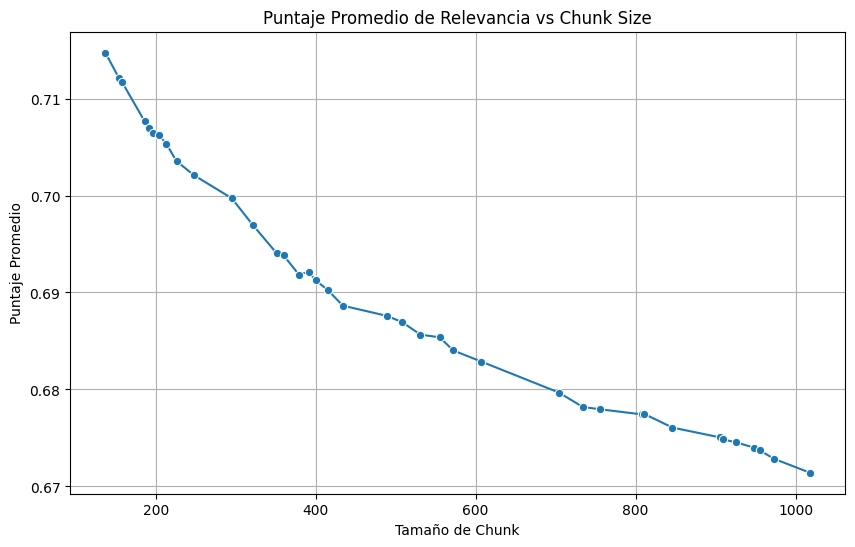

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=agrupado, x="chunk_size", y="media", marker="o")
plt.title("Puntaje Promedio de Relevancia vs Chunk Size")
plt.xlabel("Tamaño de Chunk")
plt.ylabel("Puntaje Promedio")
plt.grid(True)
plt.show()

/home/cfm47/repos/CartaIA/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


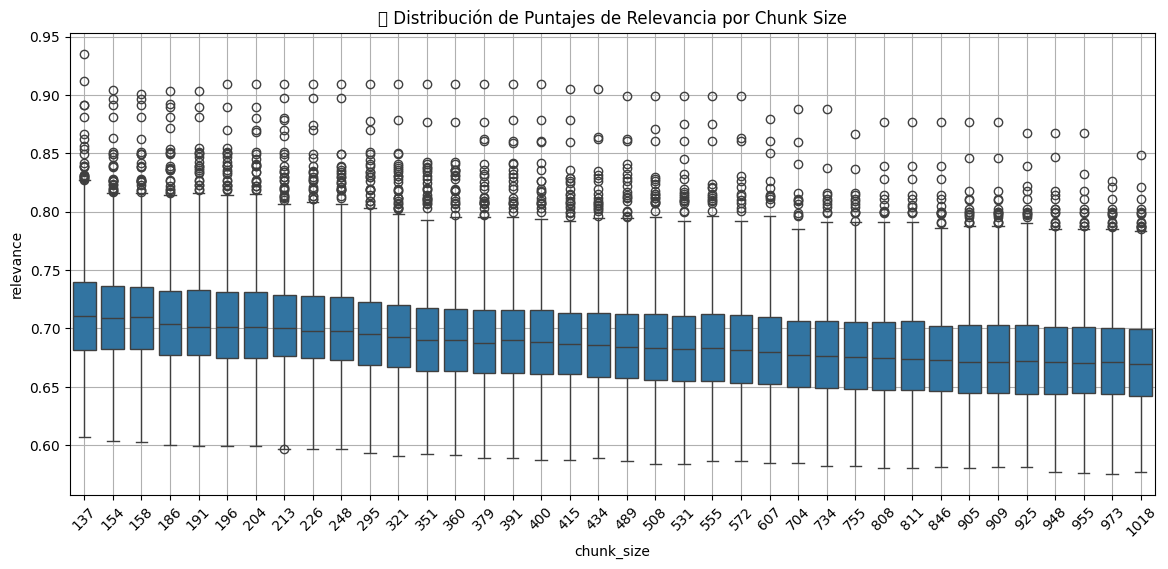

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="chunk_size", y="relevance")
plt.title("Distribución de Puntajes de Relevancia por Chunk Size")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()